In [44]:
import pandas as pd

df = pd.read_csv("data_clean.csv")

In [2]:
df.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,pickup_hour,distance_m,zone
0,2020-03-26 01:23:31,35021,12.934723,77.615610,12.916122,77.61019,1,2140.229552,"(12.934723, 77.61561)"
1,2020-03-26 01:27:20,98185,12.962879,77.719140,12.930351,77.63338,1,9977.204702,"(12.962879, 77.71914)"
2,2020-03-26 01:27:29,90067,12.930832,77.612490,13.058285,77.68921,1,16373.394501,"(12.930832, 77.61249000000002)"
3,2020-03-26 01:28:11,90067,12.930996,77.612540,13.058285,77.68921,1,16355.012070,"(12.930996, 77.61254)"
4,2020-03-26 01:28:27,90067,12.930992,77.612526,13.058285,77.68921,1,16356.165587,"(12.930992, 77.612526)"


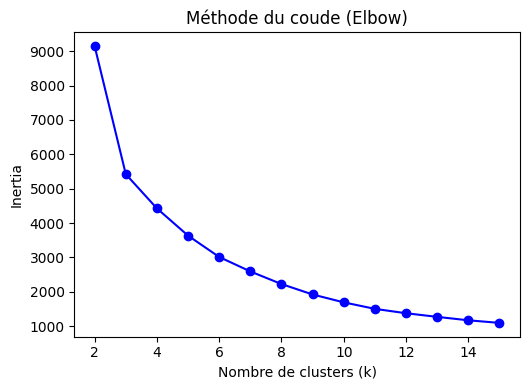

In [45]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Chargement du DataFrame nettoyé 
df = pd.read_csv("data_clean.csv")

df['ts'] = pd.to_datetime(df['ts'])

# Features temporelles
df['day_of_week'] = df['ts'].dt.dayofweek
df['hour'] = df['ts'].dt.hour
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


# Zones géographiques avec K-means
coords = df[['pick_lat', 'pick_lng']]

inertias = []

K = range(2, 16)  # on teste k de 2 à 15

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(coords)
    inertias.append(kmeans.inertia_)

#  Elbow
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K, inertias, 'bo-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertia')
plt.title('Méthode du coude (Elbow)')



plt.tight_layout()
plt.show()



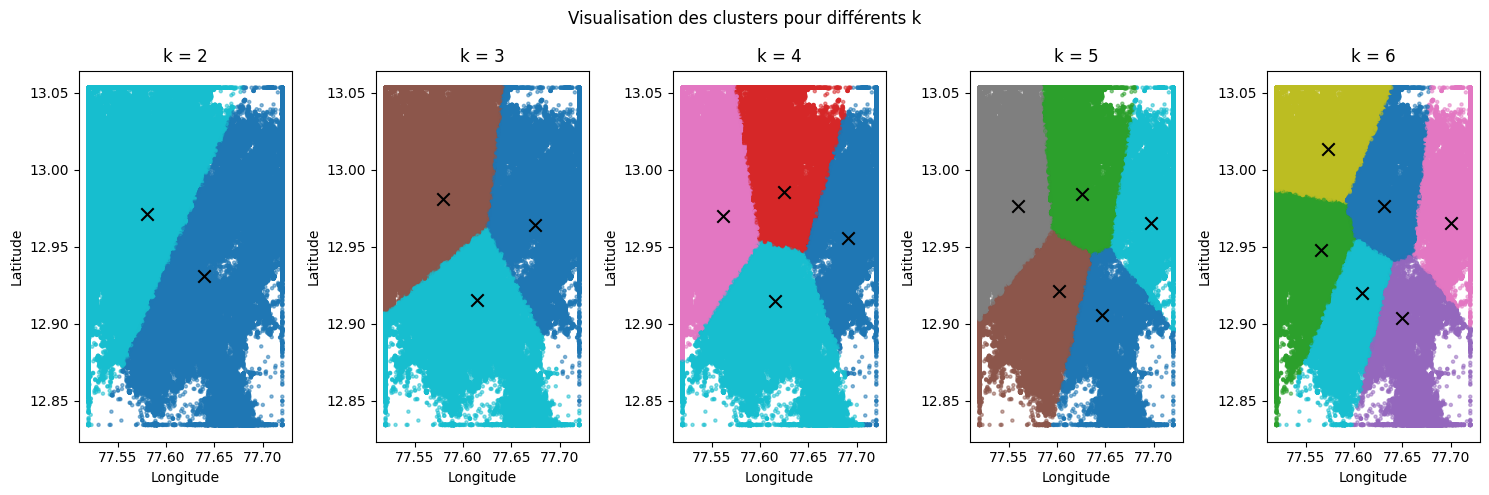

In [46]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Coordonnées des points
coords = df[['pick_lat', 'pick_lng']]

# Liste des k à tester
Ks = [2, 3, 4,5,6]

plt.figure(figsize=(15, 5))

for i, k in enumerate(Ks, start=1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(coords)
    centers = kmeans.cluster_centers_

    # Création du graphique
    plt.subplot(1, len(Ks), i)
    plt.scatter(coords['pick_lng'], coords['pick_lat'], c=labels, cmap='tab10', s=5, alpha=0.5)
    plt.scatter(centers[:, 1], centers[:, 0], c='black', marker='x', s=80)  # centres
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"k = {k}")

plt.suptitle("Visualisation des clusters pour différents k")
plt.tight_layout()
plt.show()


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

coords = df[['pick_lat', 'pick_lng']]

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)


In [48]:
k = 5  # ou le nombre de clusters que tu as choisi via la méthode du coude
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['pick_zone'] = kmeans.fit_predict(coords_scaled)

In [49]:
# Nous allons denombrer le nombre de demande par heure , jour 

# Création de la demande si elle n'existe pas
if 'demand' not in df.columns:
    df['demand'] = df.groupby(['pick_zone', 'day_of_week', 'hour'])['pick_lat'].transform('count')


In [53]:
df.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,pickup_hour,distance_m,zone,day_of_week,hour,is_weekend,pick_zone,demand
0,2020-03-26 01:23:31,35021,12.934723,77.615610,12.916122,77.61019,1,2140.229552,"(12.934723, 77.61561)",3,1,0,0,1441
1,2020-03-26 01:27:20,98185,12.962879,77.719140,12.930351,77.63338,1,9977.204702,"(12.962879, 77.71914)",3,1,0,1,301
2,2020-03-26 01:27:29,90067,12.930832,77.612490,13.058285,77.68921,1,16373.394501,"(12.930832, 77.61249000000002)",3,1,0,0,1441
3,2020-03-26 01:28:11,90067,12.930996,77.612540,13.058285,77.68921,1,16355.012070,"(12.930996, 77.61254)",3,1,0,0,1441
4,2020-03-26 01:28:27,90067,12.930992,77.612526,13.058285,77.68921,1,16356.165587,"(12.930992, 77.612526)",3,1,0,0,1441


In [52]:
demand_summary = df.groupby(['pick_zone', 'day_of_week', 'hour'])['demand'].mean().reset_index()
print(demand_summary.head())

   pick_zone  day_of_week  hour  demand
0          0            0     0  1917.0
1          0            0     1   653.0
2          0            0     2   269.0
3          0            0     3   142.0
4          0            0     4   126.0


In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# 1. Préparation des données
X = df[['pick_zone', 'day_of_week', 'hour']]  # uniquement les variables explicatives
y = df['demand']  # cible


In [68]:
# Nous avons la variable "Demand" qui est fonction d'un groupe ('pick_zone', 'day_of_week', 'hour'), du coup il ne faudrait pas
# qu'un groupe qui se trouve dans le split se trouve dans le test .

from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df['pick_zone'].astype(str) + "_" + df['day_of_week'].astype(str) + "_" + df['hour'].astype(str)

train_idx, test_idx = next(gss.split(df, groups=groups))

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]


In [70]:

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
y_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")


RMSE: 1167.56
MAE: 720.47
R2: 0.98


In [72]:
# Nous allons utiliser un autre algorithme de machine learning dui l'arbre de decision pour la regression et voir les differences .

In [73]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Instancier le modèle
dt = DecisionTreeRegressor(random_state=42)

# Entraîner sur le train set
dt.fit(X_train, y_train)

# Prédire sur le test set
y_pred = dt.predict(X_test)


In [74]:
# Évaluer
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

RMSE: 1186.04
MAE: 741.25
R2: 0.98


In [77]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Instanciation du modèle
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)


# Entraînement
gbr.fit(X_train, y_train)

# Prédiction
y_pred = gbr.predict(X_test)



In [79]:
# Évaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Gradient Boosting Regressor :")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")


Gradient Boosting Regressor :
RMSE: 2267.94
MAE: 1673.79
R2: 0.91


In [ ]:
Interpretation : 

Random Forest a la meilleure performance globale : plus faible RMSE et MAE, et un R² très proche de 1, ce qui signifie qu’il explique très bien la
variance des données.

Decision Tree est un peu moins performant que Random Forest, mais reste très proche en termes de qualité, ce qui est normal car Random Forest est un 
ensemble de plusieurs arbres, plus robuste et moins sujet au sur-apprentissage.

Gradient Boosting donne des erreurs plus élevées (RMSE et MAE plus grandes) et un R² plus bas, indiquant une moins bonne capacité à prédire dans ce 
contexte spécifique. 

Conclusion :

Pour le projet, Random Forest est le choix le plus performant à ce stade. Tu peux continuer à l’optimiser ou tester d’autres modèles, mais ce résultat 
est déjà très solide.

